# Exercise 3: FPGA Inference and Performance Analysis - SOLUTION

## Objectives
In this exercise, you will:

0. Download all the pre-built bitstream files (each of them corresponds to a different hls4ml configuration) of the encoder model 
1. Run inference on the FPGA hardware
2. Collect performance metrics (latency, throughput)
3. Compare hardware predictions with software predictions
4. Analyze the differences and understand the trade-offs

## Part 0: Download all the pre-built bitstream files

In [1]:
%%bash

# Array of firmware files
firmware_files=(
    "firmware-01_baseline.xclbin"
    "firmware-02_optimized_precision.xclbin"
    "firmware-03_extreme_precision.xclbin"
    "firmware-04_ultra_extreme_precision.xclbin"
    "firmware-05_reuse_2.xclbin"
    "firmware-06_reuse_4.xclbin"
    "firmware-07_reuse_8.xclbin"
    "firmware-09_resource_strategy.xclbin"
    "firmware-11_optimized_precision_reuse_2.xclbin"
    "firmware-12_optimized_precision_reuse_8.xclbin"
    "firmware-13_extreme_precision_reuse_8.xclbin"
    "firmware-14_extreme_precision_io_stream.xclbin"
    "firmware-15_area_optimized.xclbin",
    "firmware-16_resource_strategy_reuse_8.xclbin"
)

base_url="https://minio.131.154.98.45.myip.cloud.infn.it/public-data/firmware-hackathon"

# Download each firmware file if it doesn't exist
for firmware in "${firmware_files[@]}"; do
    if [ -f "$firmware" ]; then
        echo "Skipping $firmware (already exists)"
    else
        echo "Downloading $firmware..."
        wget -q "$base_url/$firmware"
    fi
done

Skipping firmware-01_baseline.xclbin (already exists)
Skipping firmware-02_optimized_precision.xclbin (already exists)
Skipping firmware-03_extreme_precision.xclbin (already exists)
Skipping firmware-04_ultra_extreme_precision.xclbin (already exists)
Skipping firmware-05_reuse_2.xclbin (already exists)
Skipping firmware-06_reuse_4.xclbin (already exists)
Skipping firmware-07_reuse_8.xclbin (already exists)
Skipping firmware-09_resource_strategy.xclbin (already exists)
Skipping firmware-11_optimized_precision_reuse_2.xclbin (already exists)
Skipping firmware-12_optimized_precision_reuse_8.xclbin (already exists)
Skipping firmware-13_extreme_precision_reuse_8.xclbin (already exists)
Skipping firmware-14_extreme_precision_io_stream.xclbin (already exists)
Skipping firmware-16_resource_strategy_reuse_8.xclbin (already exists)


## Part 1: Environment Setup

In [2]:
import os
os.environ["PATH"]=os.environ["PATH"]+":"+os.environ["BONDMACHINE_DIR"]
os.environ['XILINX_HLS'] = '/tools/Xilinx/Vitis_HLS/2023.2'
os.environ['XILINX_VIVADO'] = '/tools/Xilinx/Vivado/2023.2'
os.environ['XILINX_VITIS'] = '/tools/Xilinx/Vitis/2023.2'
os.environ['PATH']=os.environ["PATH"]+":"+os.environ['XILINX_HLS']+"/bin:"+os.environ['XILINX_VIVADO']+"/bin:"+os.environ['XILINX_VITIS']+"/bin:"
os.environ['XILINX_XRT'] = '/opt/xilinx/xrt'
os.environ['LD_LIBRARY_PATH'] = '/opt/xilinx/xrt/lib'

notebook_directory = os.path.abspath(os.path.dirname((os.environ["JPY_SESSION_NAME"])))
os.chdir(notebook_directory)

In [3]:
from utils import NeuralNetworkOverlay
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import os

current_dir = os.getcwd()

inference_dir = os.path.join(current_dir, 'inference')
os.makedirs(inference_dir, exist_ok=True)

print("Loading test data from file...")
X_test = np.load(os.path.join(current_dir, 'X_test.npy'))
print(f"Test data shape: {X_test.shape}")

/opt/conda/envs/hls4ml-env/lib/python3.10/site-packages/pydantic/_internal/_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)
/opt/conda/envs/hls4ml-env/lib/python3.10/site-packages/pynqutils/build_utils/xsa_parser.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/opt/conda/envs/hls4ml-env/lib/python3.10/site-packages/pydantic/_internal/_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)
2025-11-22 09:02:54.916768: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off e

Loading test data from file...
Test data shape: (655360, 64, 1)


## Part 2: FPGA Hardware Inference

### Task 2.1: Load the FPGA Overlay - SOLUTION

In [4]:
# SOLUTION: Load the FPGA overlay
print("Loading FPGA overlay...")
ol = NeuralNetworkOverlay(xclbin_name="firmware-01_baseline.xclbin")
print("FPGA overlay loaded...")
print(ol)

# You will discover that ol is an instance of the custom class NeuralNetworkOverlay which inherits from the PYNQ Overlay class
# You may ask youserlf, what is PYNQ? PYNQ is a Python-based framework for using Xilinx FPGAs and lets you control FPGA hardware directly from Python
# It loads the FPGA bitstream file by default and you can ispect the properties of this object by running the next cell

Loading FPGA overlay...


FPGA overlay loaded...


In [5]:
ol.ip_dict

{'krnl_rtl_1': {'phys_addr': 8388608,
  'addr_range': 4096,
  'type': 'fastmachinelearning.org:hls4ml:krnl_rtl:1.0',
  'hw_control_protocol': 'ap_ctrl_hs',
  'fullpath': 'krnl_rtl_1',
  'registers': {'CTRL': {'address_offset': 0,
    'access': 'read-write',
    'size': 4,
    'description': 'OpenCL Control Register',
    'type': 'unsigned int',
    'id': None,
    'fields': {'AP_START': {'access': 'read-write',
      'bit_offset': 0,
      'bit_width': 1,
      'description': 'Start the accelerator'},
     'AP_DONE': {'access': 'read-only',
      'bit_offset': 1,
      'bit_width': 1,
      'description': 'Accelerator has finished - cleared on read'},
     'AP_IDLE': {'access': 'read-only',
      'bit_offset': 2,
      'bit_width': 1,
      'description': 'Accelerator is idle'},
     'AP_READY': {'access': 'read-only',
      'bit_offset': 3,
      'bit_width': 1,
      'description': 'Accelerator is ready to start next computation'},
     'AUTO_RESTART': {'access': 'read-write',
      

### Task 2.2: Run Hardware Inference with Performance Profiling - SOLUTION

In [8]:
# SOLUTION: Run inference on FPGA hardware with profiling
output_shape = (X_test.shape[0], 8) # Why 8? Where does the 8 come from?
y_hw, latency, throughput = ol.predict(X_test, output_shape, profile=True)

Classified 655360 samples in 0.472365 seconds (1387401.6914885736 inferences / s)
Or 0.7207717895507811 us / inferences


### Task 2.3: Display Hardware Predictions - SOLUTION

In [9]:
# SOLUTION: Display the hardware predictions
print("\nHardware predictions:")
print(y_hw)
print(f"\nShape: {y_hw.shape}")
print(f"Type: {type(y_hw)}")


Hardware predictions:
[[-0.0390625  0.        -0.0390625 ... -0.078125  -0.0390625 -0.046875 ]
 [-0.0390625  0.        -0.0546875 ... -0.0703125 -0.046875  -0.0390625]
 [-0.046875   0.        -0.046875  ... -0.0703125 -0.0390625 -0.03125  ]
 ...
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]]

Shape: (655360, 8)
Type: <class 'pynq.buffer.PynqBuffer'>


### Task 2.4: Analyze Performance Metrics - SOLUTION

In [10]:
# SOLUTION: Print performance metrics
num_samples = X_test.shape[0]
time_per_inference_us = (latency / num_samples) * 1e6

print("\n=== FPGA Hardware Performance Metrics ===")
print(f"Total samples processed   : {num_samples}")
print(f"Total time (latency)      : {latency:.6f} seconds")
print(f"Throughput                : {throughput:.2f} inferences/second")
print(f"Time per inference        : {time_per_inference_us:.4f} microseconds")
print(f"\nPerformance Summary:")
print(f"  - The FPGA can process {throughput:.0f} inferences per second")
print(f"  - Each inference takes approximately {time_per_inference_us:.2f} μs")


=== FPGA Hardware Performance Metrics ===
Total samples processed   : 655360
Total time (latency)      : 0.472365 seconds
Throughput                : 1387401.69 inferences/second
Time per inference        : 0.7208 microseconds

Performance Summary:
  - The FPGA can process 1387402 inferences per second
  - Each inference takes approximately 0.72 μs


### Cleanup: Free the FPGA Overlay

In [11]:
ol.free_overlay()
print("FPGA overlay freed.")

FPGA overlay freed.


## Part 3: Software (CPU) Inference

### Task 3.1: Load the Software Model and Run Inference - SOLUTION

In [12]:
# SOLUTION: Load the Keras encoder model
encoder = load_model('autoencoder/small_encoder.keras')
print("Software encoder model loaded.")

Software encoder model loaded.


In [13]:
# SOLUTION: Run CPU inference
y_cpu = encoder.predict(X_test)
print(y_cpu)
print(f"\nCPU predictions shape: {y_cpu.shape}")

20480/20480 [==============================] - 18s 862us/step
[[-5.4413678e-05  3.8988732e-05 -1.1447490e-05 ... -1.1250250e-05
  -3.8076345e-05 -9.9376075e-07]
 [-5.4413678e-05  3.8988732e-05 -1.1447490e-05 ... -1.1250250e-05
  -3.8076345e-05 -9.9376075e-07]
 [-5.4413678e-05  3.8988732e-05 -1.1447490e-05 ... -1.1250250e-05
  -3.8076345e-05 -9.9376075e-07]
 ...
 [-5.4413678e-05  3.8988732e-05 -1.1447490e-05 ... -1.1250250e-05
  -3.8076345e-05 -9.9376075e-07]
 [-5.4413678e-05  3.8988732e-05 -1.1447490e-05 ... -1.1250250e-05
  -3.8076345e-05 -9.9376075e-07]
 [-5.4413678e-05  3.8988732e-05 -1.1447490e-05 ... -1.1250250e-05
  -3.8076345e-05 -9.9376075e-07]]

CPU predictions shape: (655360, 8)


## Part 4: Compare Hardware vs Software Predictions

### Task 4.1: Convert Hardware Predictions to NumPy Array - SOLUTION

In [14]:
# SOLUTION: Convert y_hw to a NumPy array
y_hls = np.asarray(y_hw)
print(f"Hardware predictions converted to NumPy array.")
print(f"Shape: {y_hls.shape}, Type: {type(y_hls)}")

Hardware predictions converted to NumPy array.
Shape: (655360, 8), Type: <class 'numpy.ndarray'>


### Task 4.2: Calculate Comparison Metrics - SOLUTION

In [15]:
# SOLUTION: Calculate comparison metrics
# MSE per sample: mean squared error for each sample across all features
mse_per_sample = np.mean((y_cpu - y_hls)**2, axis=1)

# Overall MSE: average of all MSE values
overall_mse = np.mean(mse_per_sample)

# MAE: mean absolute error across all predictions
mae = np.mean(np.abs(y_cpu - y_hls))

# RMSE: square root of overall MSE
rmse = np.sqrt(overall_mse)

# Print the metrics
print(f"\n=== Software vs Hardware Reconstruction Metrics ===")
print(f"Overall MSE           : {overall_mse:.6f}")
print(f"Average MSE per sample: {np.mean(mse_per_sample):.6f}")
print(f"Min MSE               : {np.min(mse_per_sample):.6f}")
print(f"Max MSE               : {np.max(mse_per_sample):.6f}")
print(f"Mean Absolute Error   : {mae:.6f}")
print(f"RMSE                  : {rmse:.6f}")

print(f"\nInterpretation:")
print(f"  - Lower values indicate better agreement between HW and SW")
print(f"  - The differences are due to quantization in the FPGA implementation")


=== Software vs Hardware Reconstruction Metrics ===
Overall MSE           : 0.001057
Average MSE per sample: 0.001057
Min MSE               : 0.000000
Max MSE               : 0.003526
Mean Absolute Error   : 0.021556
RMSE                  : 0.032515

Interpretation:
  - Lower values indicate better agreement between HW and SW
  - The differences are due to quantization in the FPGA implementation


### Task 4.3: Visualize the Comparison


Comparison plot saved as 'cpu_hls_comparison.png'


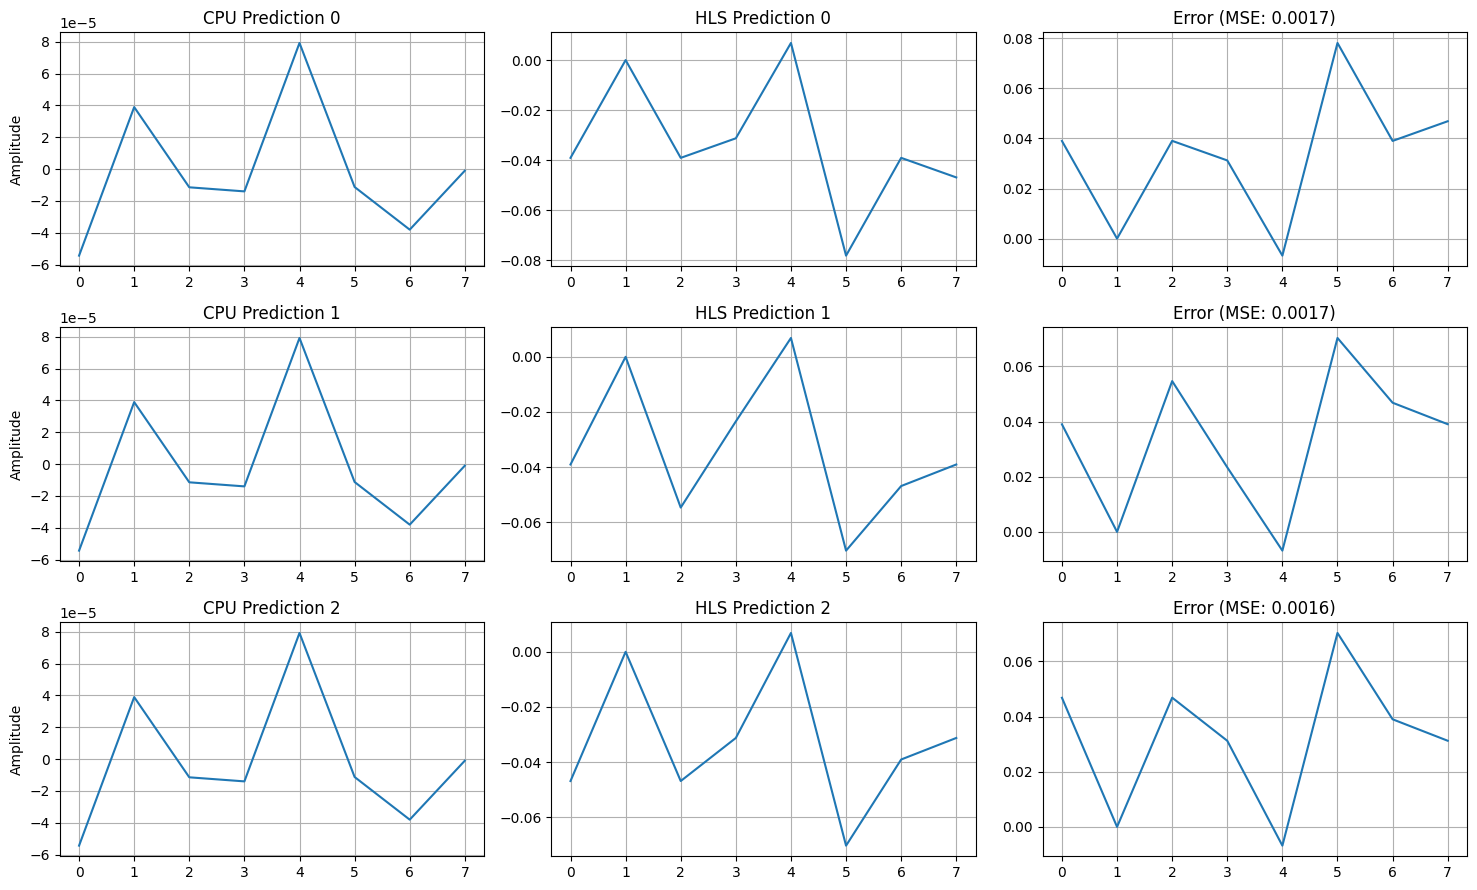

In [16]:
# Visualize comparison for first 3 samples
n_examples = 3
fig, axes = plt.subplots(n_examples, 3, figsize=(15, 3*n_examples))

for i in range(n_examples):
    # CPU predictions
    axes[i, 0].plot(y_cpu[i])
    axes[i, 0].set_title(f'CPU Prediction {i}')
    axes[i, 0].set_ylabel('Amplitude')
    axes[i, 0].grid(True)
    
    # HLS predictions
    axes[i, 1].plot(y_hls[i])
    axes[i, 1].set_title(f'HLS Prediction {i}')
    axes[i, 1].grid(True)
    
    # Difference
    axes[i, 2].plot(y_cpu[i] - y_hls[i])
    axes[i, 2].set_title(f'Error (MSE: {mse_per_sample[i]:.4f})')
    axes[i, 2].grid(True)

plt.tight_layout()
plt.savefig('cpu_hls_comparison.png')
print("\nComparison plot saved as 'cpu_hls_comparison.png'")

Error distribution plot saved as 'error_distribution.png'


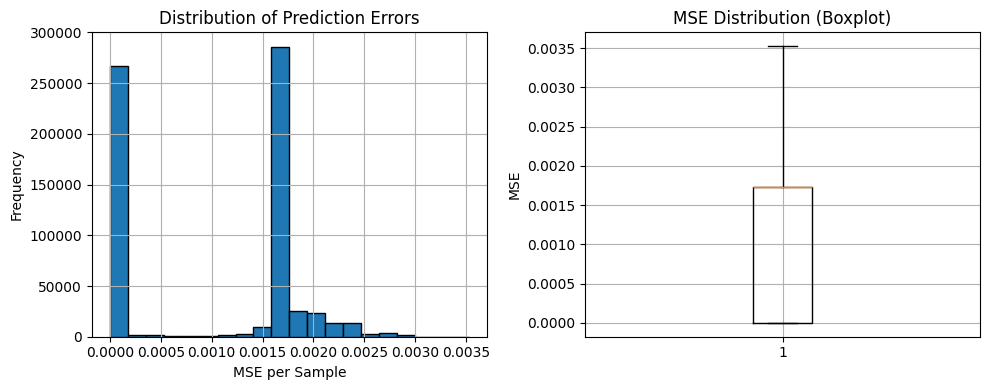

In [17]:
# Visualize error distribution
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(mse_per_sample, bins=20, edgecolor='black')
plt.xlabel('MSE per Sample')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.boxplot(mse_per_sample)
plt.ylabel('MSE')
plt.title('MSE Distribution (Boxplot)')
plt.grid(True)

plt.tight_layout()
plt.savefig('error_distribution.png')
print("Error distribution plot saved as 'error_distribution.png'")

## Part 5: Latency Comparison - FPGA vs CPU

Now let's compare the inference latencies between FPGA and CPU to understand the performance benefits of hardware acceleration.

### Task 5.1: Measure CPU Inference Latency - SOLUTION

In [18]:
# SOLUTION: Measure CPU inference latency
import time

print("Measuring CPU inference latency...")

start_time = time.time()
_ = encoder.predict(X_test, verbose=0)
end_time = time.time()

cpu_latency = end_time - start_time

print(f"CPU inference completed in {cpu_latency:.6f} seconds")

Measuring CPU inference latency...
CPU inference completed in 18.654742 seconds


### Task 5.2: Calculate Performance Metrics - SOLUTION

In [19]:
# SOLUTION: Calculate comparison metrics
num_samples = X_test.shape[0]

# Calculate all metrics
speedup = cpu_latency / latency
cpu_throughput = num_samples / cpu_latency
cpu_time_per_inference = (cpu_latency / num_samples) * 1e6  # in microseconds
fpga_latency = latency
fpga_throughput = throughput
fpga_time_per_inference = (latency / num_samples) * 1e6  # in microseconds

# Print comparison table
print("\n" + "="*70)
print("LATENCY COMPARISON: FPGA vs CPU")
print("="*70)
print(f"\n{'Metric':<30} {'FPGA':<20} {'CPU':<20}")
print("-"*70)
print(f"{'Total Latency (seconds)':<30} {fpga_latency:<20.6f} {cpu_latency:<20.6f}")
print(f"{'Throughput (inferences/sec)':<30} {fpga_throughput:<20.2f} {cpu_throughput:<20.2f}")
print(f"{'Time per Inference (μs)':<30} {fpga_time_per_inference:<20.4f} {cpu_time_per_inference:<20.4f}")
print("-"*70)
print(f"{'SPEEDUP FACTOR':<30} {speedup:<20.2f}x {'1.00x':<20}")
print("="*70)
print(f"\nThe FPGA is {speedup:.2f}x faster than the CPU for this inference task.")
print(f"\nInterpretation:")
print(f"  - FPGA processes {fpga_throughput:.0f} inferences/sec vs CPU's {cpu_throughput:.0f} inferences/sec")
print(f"  - Each inference takes {fpga_time_per_inference:.2f}μs on FPGA vs {cpu_time_per_inference:.2f}μs on CPU")
print(f"  - For real-time applications, this speedup can be critical")


LATENCY COMPARISON: FPGA vs CPU

Metric                         FPGA                 CPU                 
----------------------------------------------------------------------
Total Latency (seconds)        0.472365             18.654742           
Throughput (inferences/sec)    1387401.69           35131.01            
Time per Inference (μs)        0.7208               28.4649             
----------------------------------------------------------------------
SPEEDUP FACTOR                 39.49               x 1.00x               

The FPGA is 39.49x faster than the CPU for this inference task.

Interpretation:
  - FPGA processes 1387402 inferences/sec vs CPU's 35131 inferences/sec
  - Each inference takes 0.72μs on FPGA vs 28.46μs on CPU
  - For real-time applications, this speedup can be critical


### Task 5.3: Visualize Latency Comparison


Latency comparison plot saved as 'latency_comparison.png'


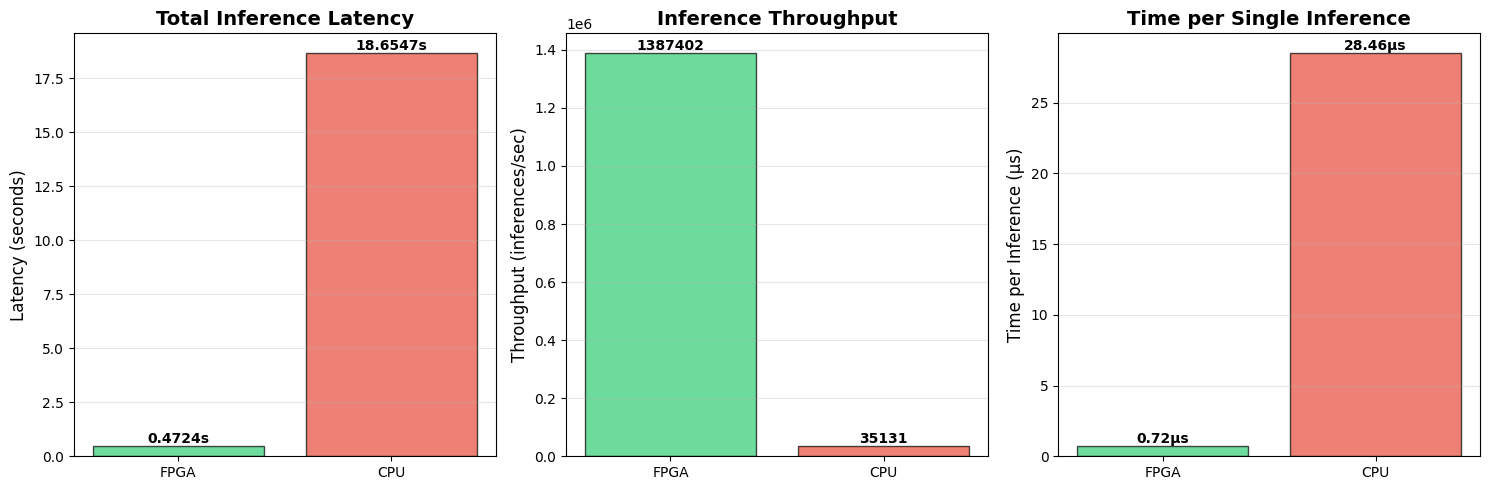

In [20]:
# Create comparison visualizations
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Total Latency Comparison
platforms = ['FPGA', 'CPU']
latencies = [fpga_latency, cpu_latency]
colors = ['#2ecc71', '#e74c3c']

axes[0].bar(platforms, latencies, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Latency (seconds)', fontsize=12)
axes[0].set_title('Total Inference Latency', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(latencies):
    axes[0].text(i, v, f'{v:.4f}s', ha='center', va='bottom', fontweight='bold')

# Plot 2: Throughput Comparison
throughputs = [fpga_throughput, cpu_throughput]
axes[1].bar(platforms, throughputs, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Throughput (inferences/sec)', fontsize=12)
axes[1].set_title('Inference Throughput', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(throughputs):
    axes[1].text(i, v, f'{v:.0f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Time per Inference Comparison
times_per_inf = [fpga_time_per_inference, cpu_time_per_inference]
axes[2].bar(platforms, times_per_inf, color=colors, alpha=0.7, edgecolor='black')
axes[2].set_ylabel('Time per Inference (μs)', fontsize=12)
axes[2].set_title('Time per Single Inference', fontsize=14, fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)
for i, v in enumerate(times_per_inf):
    axes[2].text(i, v, f'{v:.2f}μs', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('latency_comparison.png', dpi=300, bbox_inches='tight')
print("\nLatency comparison plot saved as 'latency_comparison.png'")
plt.show()

Speedup comparison plot saved as 'speedup_comparison.png'


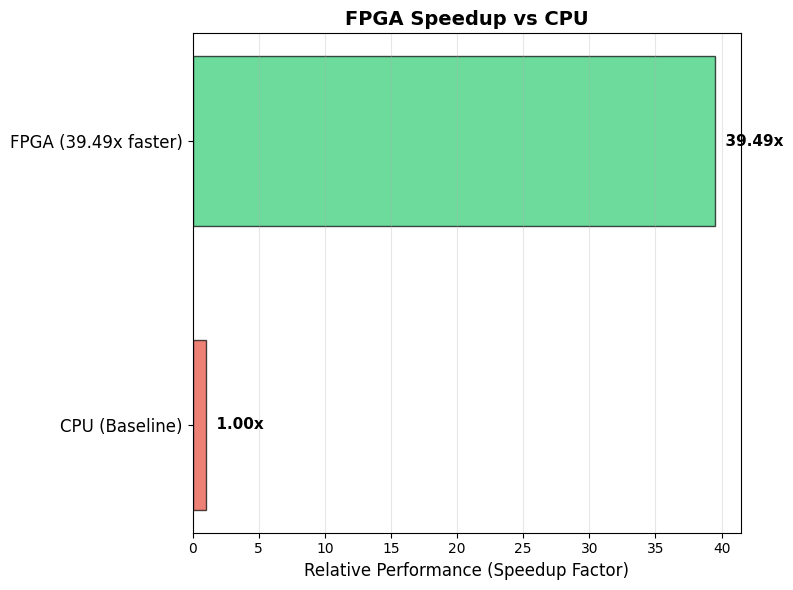

In [21]:
# Speedup visualization
fig, ax = plt.subplots(figsize=(8, 6))

# Create a horizontal bar showing speedup
y_pos = [0, 1]
performance = [1.0, speedup]
labels = ['CPU (Baseline)', f'FPGA ({speedup:.2f}x faster)']
colors_speedup = ['#e74c3c', '#2ecc71']

bars = ax.barh(y_pos, performance, color=colors_speedup, alpha=0.7, edgecolor='black', height=0.6)
ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize=12)
ax.set_xlabel('Relative Performance (Speedup Factor)', fontsize=12)
ax.set_title('FPGA Speedup vs CPU', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, performance)):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, 
            f'  {val:.2f}x', 
            ha='left', va='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('speedup_comparison.png', dpi=300, bbox_inches='tight')
print("Speedup comparison plot saved as 'speedup_comparison.png'")
plt.show()

## Part 6: Simulated vs Real Latency Comparison

In this final part, we compare the **simulated latency** (from HLS synthesis) with the **real measured latency** from the FPGA.

### Task 6.1: Get Simulated Latency and Clock Frequency - SOLUTION

In [22]:
# SOLUTION: Input simulated latency from HLS synthesis
# This value comes from the synthesis report
# Example: If your synthesis report shows 52 clock cycles
simulated_clock_cycles = 52  # Replace with actual value from your synthesis

# Get FPGA clock frequency
# Common FPGA clock frequencies: 100 MHz, 150 MHz, 200 MHz, 250 MHz
# Try to get from overlay first, otherwise use known value
try:
    # Try common property names
    if hasattr(ol, 'clock_freq'):
        fpga_clock_freq_mhz = ol.clock_freq
    elif hasattr(ol, 'frequency_mhz'):
        fpga_clock_freq_mhz = ol.frequency_mhz
    else:
        # Use typical frequency for Alveo/Zynq boards
        fpga_clock_freq_mhz = 200  # MHz (typical for Alveo U280/U250)
        print("Note: Using default clock frequency of 200 MHz")
except:
    fpga_clock_freq_mhz = 200  # MHz
    print("Note: Using default clock frequency of 200 MHz")

print(f"Simulated latency: {simulated_clock_cycles} clock cycles")
print(f"FPGA clock frequency: {fpga_clock_freq_mhz} MHz")

Note: Using default clock frequency of 200 MHz
Simulated latency: 52 clock cycles
FPGA clock frequency: 200 MHz


### Task 6.2: Calculate Theoretical Latency from Simulation - SOLUTION

In [23]:
# SOLUTION: Calculate theoretical latency
# Time (μs) = clock_cycles / frequency_MHz
theoretical_latency_us = simulated_clock_cycles / fpga_clock_freq_mhz

print(f"\nTheoretical latency (from simulation): {theoretical_latency_us:.4f} μs per inference")
print(f"\nCalculation: {simulated_clock_cycles} cycles / {fpga_clock_freq_mhz} MHz = {theoretical_latency_us:.4f} μs")


Theoretical latency (from simulation): 0.2600 μs per inference

Calculation: 52 cycles / 200 MHz = 0.2600 μs


### Task 6.3: Compare with Real Measured Latency - SOLUTION

In [24]:
# SOLUTION: Compare simulated vs real latency
real_latency_us = fpga_time_per_inference  # From Part 5

# Calculate overhead factor
overhead_factor = real_latency_us / theoretical_latency_us
additional_latency_us = real_latency_us - theoretical_latency_us
overhead_percentage = ((overhead_factor - 1.0) * 100)

# Print comparison
print("\n" + "="*70)
print("SIMULATED vs REAL LATENCY COMPARISON")
print("="*70)
print(f"\n{'Metric':<35} {'Value':<20}")
print("-"*70)
print(f"{'Simulated clock cycles':<35} {simulated_clock_cycles:<20}")
print(f"{'FPGA clock frequency (MHz)':<35} {fpga_clock_freq_mhz:<20}")
print(f"{'Theoretical latency (μs)':<35} {theoretical_latency_us:<20.4f}")
print(f"{'Real measured latency (μs)':<35} {real_latency_us:<20.4f}")
print("-"*70)
print(f"{'Overhead factor':<35} {overhead_factor:<20.2f}x")
print(f"{'Additional latency (μs)':<35} {additional_latency_us:<20.4f}")
print(f"{'Overhead percentage':<35} {overhead_percentage:<20.1f}%")
print("="*70)
print(f"\nThe real latency is {overhead_factor:.2f}x higher than the simulated latency.")
print(f"This means {overhead_percentage:.1f}% of the total latency is overhead (not computation).")


SIMULATED vs REAL LATENCY COMPARISON

Metric                              Value               
----------------------------------------------------------------------
Simulated clock cycles              52                  
FPGA clock frequency (MHz)          200                 
Theoretical latency (μs)            0.2600              
Real measured latency (μs)          0.7208              
----------------------------------------------------------------------
Overhead factor                     2.77                x
Additional latency (μs)             0.4608              
Overhead percentage                 177.2               %

The real latency is 2.77x higher than the simulated latency.
This means 177.2% of the total latency is overhead (not computation).


### Task 6.4: Visualize Simulated vs Real Latency


Simulated vs real latency plot saved as 'simulated_vs_real_latency.png'


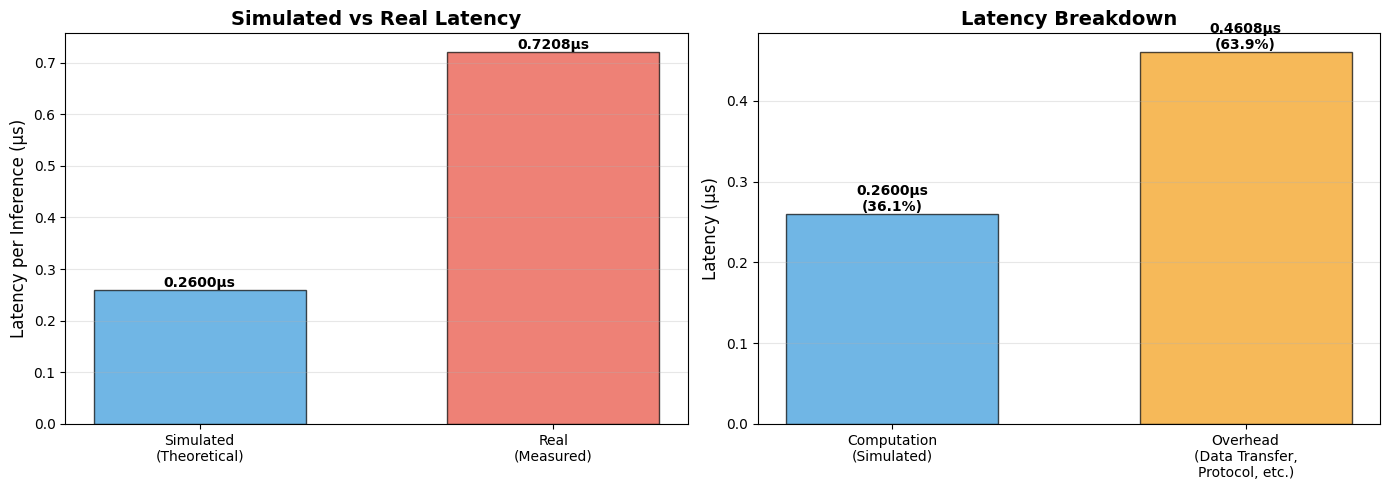

In [25]:
# Visualization of simulated vs real latency
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Latency comparison
categories = ['Simulated\n(Theoretical)', 'Real\n(Measured)']
latencies = [theoretical_latency_us, real_latency_us]
colors = ['#3498db', '#e74c3c']

bars = axes[0].bar(categories, latencies, color=colors, alpha=0.7, edgecolor='black', width=0.6)
axes[0].set_ylabel('Latency per Inference (μs)', fontsize=12)
axes[0].set_title('Simulated vs Real Latency', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, latencies)):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.4f}μs',
                ha='center', va='bottom', fontweight='bold')

# Plot 2: Breakdown of latency components
components = ['Computation\n(Simulated)', 'Overhead\n(Data Transfer,\nProtocol, etc.)']
values = [theoretical_latency_us, additional_latency_us]
colors_breakdown = ['#3498db', '#f39c12']

bars2 = axes[1].bar(components, values, color=colors_breakdown, alpha=0.7, edgecolor='black', width=0.6)
axes[1].set_ylabel('Latency (μs)', fontsize=12)
axes[1].set_title('Latency Breakdown', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels and percentages
total = sum(values)
for i, (bar, val) in enumerate(zip(bars2, values)):
    height = bar.get_height()
    percentage = (val / total) * 100
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.4f}μs\n({percentage:.1f}%)',
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('simulated_vs_real_latency.png', dpi=300, bbox_inches='tight')
print("\nSimulated vs real latency plot saved as 'simulated_vs_real_latency.png'")
plt.show()